# Generating a business case data set



In [1]:
# importing libraries

import pandas as pd
import numpy as np

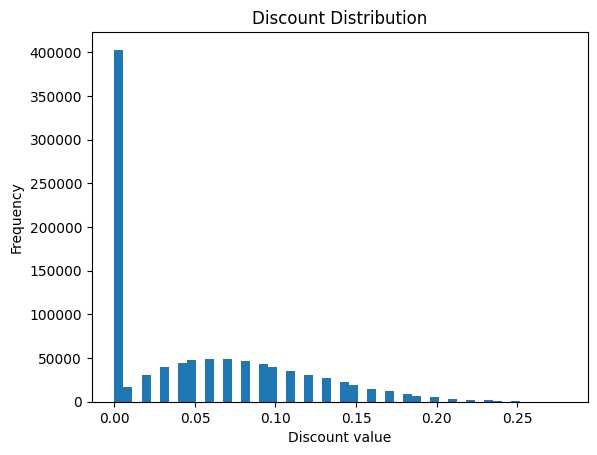

In [2]:
# Set reproducibility
np.random.seed(42)

# Number of unique rows
n = 1_000_000  # the underscore doesnt affect the value, it's just number easier to read

# Core features
product_category = np.random.choice(
    ['Energy IC', 'Microcontroller', 'Sensor', 'Connectivity'],
    size=n,
    p=[0.24, 0.38, 0.16, 0.22]  
)

base_price_raw = np.random.normal(60, 10, n)  # Example base prices before category adjustment
base_price_multiplier = np.where(product_category == 'Energy IC', 1.8,
                        np.where(product_category == 'Sensor', 0.3,
                        np.where(product_category == 'Connectivity', 1.4, 0.95)))

base_price = np.round(base_price_raw * base_price_multiplier, 2)


# Step 1: Create a binary mask — 60% will receive a discount, 40% will not
discount_mask = np.random.choice([1, 0], size=n, p=[0.6, 0.4])

# Step 2: Generate discount values only for the 60% marked as 1
discount_values = np.round((1 - np.random.beta(5, 2, n)) * 0.3, 2)

# Step 3: Combine both into a final array
discount = np.where(discount_mask == 1, discount_values, 0.00)


base_price = np.where(discount == 0, base_price * 1.1, base_price)





discount_effect = (
    -50 * (discount >= 0.15)         # high discount hurts volume the most
    -20 * ((discount >= 0.05) & (discount < 0.15))  # medium hurt slightly
    +10 * (discount < 0.05)          # low discount helps a bit
    +30 * (discount == 0)            # blank (no discount) boosts due to perceived exclusivity
)


customer_segment = np.random.choice(['Distributor', 'OEM', 'Direct'],  #original equipment manufacturer
    size=n,
    p=[0.41, 0.38, 0.21]  
)
is_peak_season = np.random.choice([0, 1], n, p=[0.8, 0.2])

# Extra features
time_on_market_days = np.random.poisson(40, n)
units_in_stock = np.random.lognormal(mean=7.5, sigma=0.5, size=n)
units_in_stock = np.clip(np.round(units_in_stock), 100, 5000).astype(int)

#marketing_spend_level = np.round(np.random.lognormal(mean=3.5, sigma=0.3, size=n), 2)
#marketing_spend_level = np.clip(marketing_spend_level, 0, 100)
marketing_spend_level = np.round(np.random.beta(2, 2, size=n) * 100, 2)


marketing_effect = 30 * np.log1p(marketing_spend_level)  


# Units sold logic
units_sold = (
    100
    + np.random.normal(0, 10, n)
    + discount_effect
    + 50 * is_peak_season
    + np.where(product_category == 'Energy IC', 60, 0)
    + np.where(product_category == 'Sensor', 40, 0)
    + np.where(product_category == 'Connectivity', 20, 0)
    + np.where(product_category == 'Microcontroller', -10, 0)
    + marketing_effect # marketing_spend_level * 0.3
    - time_on_market_days * 0.2
    + np.where(customer_segment == 'Direct', 90, 0)
    + np.where(customer_segment == 'OEM', 45, 0)
    - np.where(customer_segment == 'Distributor', 70, 0)
)


units_sold = np.round(np.clip(units_sold, 5, None)).astype(int)
revenue = np.round(base_price * (1 - discount) * units_sold, 2)

# Build base dataset - each key is the column name, with our 1D array of NUMPY having the values for each row
df = pd.DataFrame({
    'base_price': base_price,
    'discount': discount,
    'product_category': product_category,
    'customer_segment': customer_segment,
    'is_peak_season': is_peak_season,
    'time_on_market_days': time_on_market_days,
    'units_in_stock': units_in_stock,
    'marketing_spend_level': marketing_spend_level,
    'units_sold': units_sold,
    'revenue': revenue
})

df["discount_level"] = pd.cut(df["discount"],bins=[-0.01,0,0.05,0.15,0.35], labels=["blank","low","medium","high"])

df = df.drop(columns="discount")

# para linhas df = df.drop(subset=[lista])


# Introduce ~5% missing values in selected columns
null_dict = { 'base_price' : 0.03, 'discount_level' : 0.09, 'product_category': 0.08, 'marketing_spend_level': 0.04}

for col, value in null_dict.items():
    df.loc[df.sample(frac=value).index, col] = np.nan

# Add 8% duplicated rows
duplicates = df.sample(frac=0.08, random_state=42)
df = pd.concat([df, duplicates], ignore_index=True)

# Optional: shuffle rows (to make duplicates non-contiguous)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Export to CSV
df.to_csv("business_dataset.csv", index=False)

import matplotlib.pyplot as plt

plt.hist(discount, bins=50)
plt.title("Discount Distribution")
plt.xlabel("Discount value")
plt.ylabel("Frequency")
plt.show()

